# F: Tratamiento de una imagen científica (Ha-R)

Vamos a estudiar las regiones `HII` de la galaxia **NGC6118**. Para ello tendremos que preparar dos imágenes con diferentes filtros, `Ha` y `R` ya que sabemos que el filtro `Ha` es un filtro estrecho centrado en la banda 6607A y el filtro `R`, aunque está centrado en esas longitudes de onda, es más amplio.

Por lo tanto, lo que haremos es realizar una fotometría de las estrellas en la imagen `Ha` ya que tiene menos estrellas que la imagen `R` y a partir de la imagen `R` podemos añadir alguna estrella que no esté en `Ha`.

Una vez realizada la fotometría, debemos graficar los flujos de los dos filtros y trazar la recta de ajuste. Así conseguiremos realizar una estimación de la diferencia de flujo debido a los filtros.

Localizar estas regiones es importante en astronomía porque nos pueden ayudar a estudiar la velocidad radial de las galaxias como proponen [Kam, Z. S et. al.](https://ui.adsabs.harvard.edu/abs/2015MNRAS.449.4048K/abstract)

## Abriendo las imágenes

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
import os
import pandas as pd
import matplotlib.patches as patches
import scipy 

from photutils import aperture_photometry
from photutils import CircularAperture
from astropy.stats import sigma_clipped_stats
from photutils import DAOStarFinder
from photutils import make_source_mask

from mpl_toolkits.mplot3d import Axes3D
from photutils.isophote import EllipseGeometry

from sklearn.linear_model import LinearRegression 
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
ha=fits.open("imagenes/regionHII/ha.fit")[0].data[400:-400,400:-400]
r=fits.open("imagenes/regionHII/r.fit")[0].data[400:-400,400:-400]

## Detectando estrellas en `Ha`

[DAOStarFinder](https://photutils.readthedocs.io/en/stable/api/photutils.detection.DAOStarFinder.html) [Stetson 1987; PASP 99, 191](https://ui.adsabs.harvard.edu/abs/1987PASP...99..191S/abstract) busca en las imágenes los máximos de densidad en el flujo.

In [3]:
mean, median, std = sigma_clipped_stats(ha, sigma=3.0) # definimos una mediana con sigma_clipped_stats 
daofind = DAOStarFinder(fwhm=3.0, threshold=80.*std)   # detectamos las fuentes con DAOStarFinder
mask = np.zeros(ha.shape, dtype=bool)                  # Generamos una mascara para qutar el centro de la imagen
mask[200:1000, 200:1000] = True
sources = daofind(ha - median, mask=mask)              # detectamos las fuentes que esten por encima de la mediana
for col in sources.colnames:  
    sources[col].info.format = '%.8g'                  # formateo de la tabla
print(sources)  

 id xcentroid ycentroid sharpness  ... sky    peak       flux       mag     
--- --------- --------- ---------- ... --- ---------- --------- ------------
  1 349.08407  23.06115 0.45760264 ...   0 0.28782383  1.120405  -0.12343762
  2 1252.3425 111.83957  0.4999262 ...   0  1.7884092 7.9329743   -2.2485901
  3 100.84967 141.65812 0.45191612 ...   0   2.009676 7.3235306   -2.1618012
  4 139.75055 154.01524 0.49915702 ...   0 0.39054054 1.4219632  -0.38222089
  5  398.0879 182.65515 0.47621734 ...   0 0.36278591 1.5117348  -0.44868904
  6 1242.7372 644.93147 0.41871982 ...   0 0.51455635 2.4777499  -0.98514369
  7 1050.4904 648.32583 0.51884045 ...   0 0.64771599 2.9557926   -1.1766849
  8 565.11216 1021.5083 0.44126111 ...   0 0.30307603 1.3398255  -0.31762057
  9 299.00671  1132.516 0.46488908 ...   0 0.49880373 2.1088766  -0.81012793
 10 327.52825 1144.4042  0.4284047 ...   0  11.307342 47.393862   -4.1893052
 11 245.92845 1271.7488 0.45522225 ...   0 0.41422138 1.7048297  -0.57920252

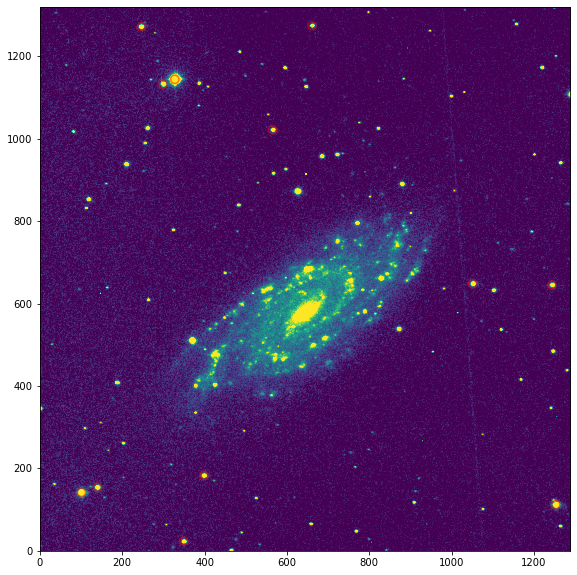

In [4]:
plt.figure("Stars in Ha", figsize=[10, 10])
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=10.)
plt.imshow(ha,vmin=0, vmax=0.01, origin='lower')
apertures.plot(color='red', lw=1.5, alpha=0.5)
plt.show()

Una vez detectadas las fuentes calculamos la apertura circular en un radio de 20 píxeles:

In [5]:
aperture = CircularAperture(positions, r=20.)

Y calculamos la fotometría de dicha apertura:

In [6]:
phot_table_Ha = aperture_photometry(ha, aperture)
phot_table_Ha

id,xcenter,ycenter,aperture_sum
,pix,pix,
int64,float64,float64,float64
1,349.0840718721037,23.06115023990617,5.9707853144109375
2,1252.3425282476803,111.8395660192342,31.12198779628524
3,100.84967175575383,141.65812290255334,46.177683387858465
4,139.75055253162196,154.01523501983976,9.187212283913759
5,398.0878982067919,182.65514850657365,7.112305744900143
6,1242.7372495712386,644.9314689138399,8.795779939807034
7,1050.4903937456747,648.3258263525412,10.492986704029342
8,565.1121596416924,1021.5082530499211,5.3790705228001165


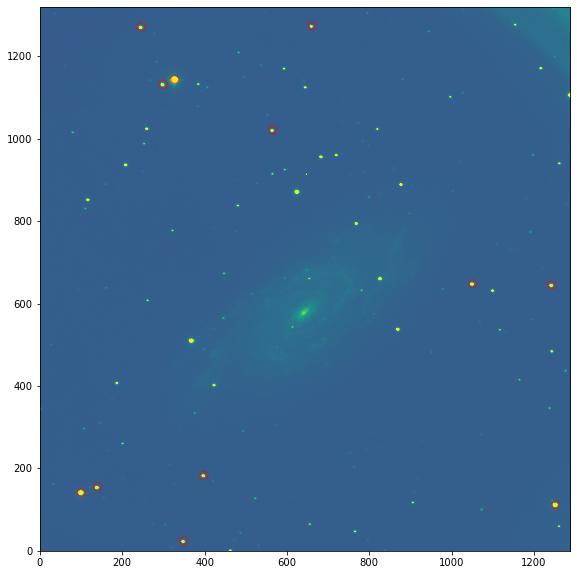

In [7]:
plt.figure("Stars in R", figsize=[10, 10])
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=10.)
plt.imshow(r, vmin=np.nanmin(r), vmax=np.nanmedian(r)*800, origin='lower')
apertures.plot(color='red', lw=1.5, alpha=0.5)
plt.show()

In [8]:
phot_table_R = aperture_photometry(r, aperture)
phot_table_R

id,xcenter,ycenter,aperture_sum
,pix,pix,
int64,float64,float64,float64
1,349.0840718721037,23.06115023990617,198.1431176575303
2,1252.3425282476803,111.8395660192342,1236.7766704090466
3,100.84967175575383,141.65812290255334,1690.1940084358525
4,139.75055253162196,154.01523501983976,307.37253223122707
5,398.0878982067919,182.65514850657365,231.46341415609555
6,1242.7372495712386,644.9314689138399,334.2297095809117
7,1050.4903937456747,648.3258263525412,360.05377588415286
8,565.1121596416924,1021.5082530499211,197.14452375154906


## Ha vs R

Comparamos el flujo de el filtro de H-alpha y el del canal rojo:

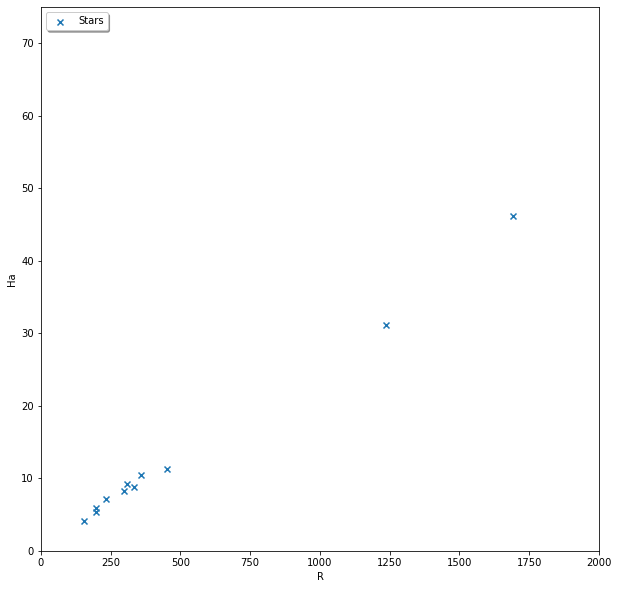

In [9]:
plt.figure("Ha vs R", figsize=[10, 10])
plt.scatter(phot_table_R['aperture_sum'],phot_table_Ha['aperture_sum'] , marker='x', alpha=1, label='Stars')
plt.xlim(0, 2000)
plt.ylim(0, 75)
plt.legend (loc='upper left', shadow=True, fontsize='medium')
plt.ylabel("Ha")
plt.xlabel("R")
plt.show()

### Ajuste lineal: $Ha = aR+b$

Realizamos un ajuste lineal para determinar la compensación de flujo:

In [10]:
# y = ax + b
regresion_lineal = LinearRegression()

regresion_lineal.fit(np.asarray(phot_table_R['aperture_sum']).reshape(-1,1), np.asarray(phot_table_Ha['aperture_sum'])) 
a = regresion_lineal.coef_
b = regresion_lineal.intercept_
print('a = ' + str(a) + ', b = ' + str(b))

a = [0.02709269], b = 0.012804110295853377


### $R^2$

In [11]:
r2 = regresion_lineal.score(np.asarray(phot_table_R['aperture_sum']).reshape(-1,1), np.asarray(phot_table_Ha['aperture_sum']))
print('Coeficiente de determinacion R2 = ' + str(r2))

Coeficiente de determinacion R2 = 0.999787706607886


### Graficando Ha vs R y su ajuste lineal

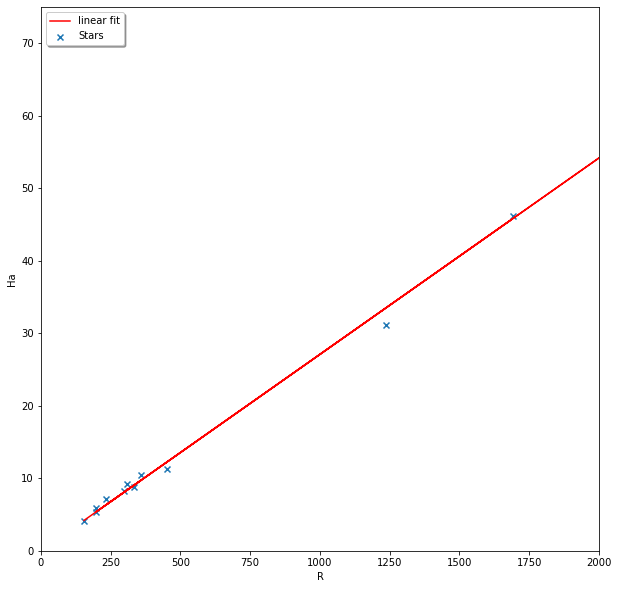

In [12]:
plt.figure("Ha vs R", figsize=[10, 10])
y_ajuste = phot_table_R['aperture_sum']*a + b
# Dibujamos la recta de ajuste
plt.plot(phot_table_R['aperture_sum'], y_ajuste, 'r-', label ='linear fit')
plt.scatter(phot_table_R['aperture_sum'],phot_table_Ha['aperture_sum'] , marker='x', alpha=1, label='Stars')
plt.xlim(0, 2000)
plt.ylim(0, 75)
plt.legend (loc='upper left', shadow=True, fontsize='medium')
plt.ylabel("Ha")
plt.xlabel("R")
plt.show()

### Multiplicando la imagen del filtro R por a

In [13]:
r_scale = r * a

### Sustrayendo la imagen R de la imagen Ha

In [14]:
Ha_R = ha - r_scale

In [15]:
Ha_R

array([[ 5.87614958e-04, -2.22705754e-03, -6.33193890e-05, ...,
        -1.95511944e-03, -2.19005413e-03, -1.07355891e-03],
       [ 1.44865865e-03,  1.68791693e-03, -2.92267763e-03, ...,
        -5.02979401e-03, -1.32460991e-04,  2.46133466e-03],
       [-1.45900960e-03, -1.07090869e-03,  6.85737659e-04, ...,
        -1.65304801e-03, -2.56703439e-03,  3.42935420e-04],
       ...,
       [-2.10557561e-03,  3.17371688e-03, -1.01978432e-03, ...,
        -8.15871924e-03, -9.66137502e-03, -6.33899882e-03],
       [-3.50515216e-04, -1.37433936e-04,  3.51346817e-03, ...,
        -9.14807545e-03, -4.38527888e-03, -9.54893225e-03],
       [-1.00476876e-03,  1.81116940e-03,  1.69438158e-03, ...,
        -5.03344479e-03, -8.53135309e-03, -6.68820593e-03]])

### Graficando Ha-R

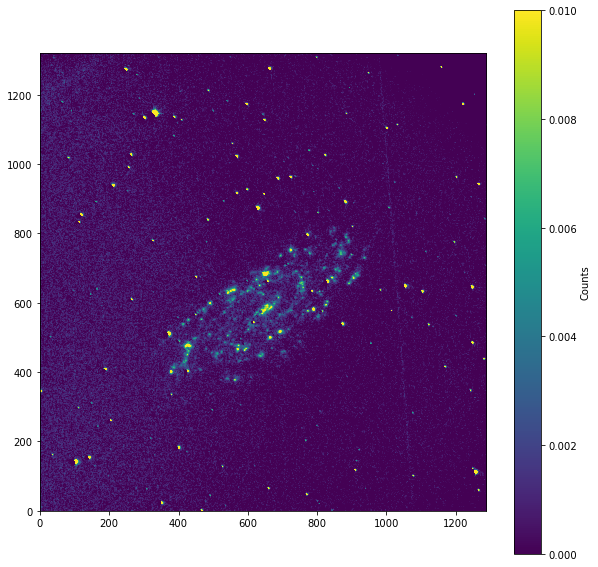

In [16]:
plt.figure("Ha-R", figsize=[10, 10])
plt.imshow(Ha_R, vmin=0, vmax=0.01, origin='lower')
plt.colorbar(label='Counts')
plt.show()  

### Guardando Ha-R

In [17]:
hdu_Ha = fits.PrimaryHDU(Ha_R.astype(np.float32))
hdu_Ha.writeto('imagenes/salidaImagenes/Ha_R.fit', overwrite=True)

## Buscando las regiones HII en nuestra imagen

La galaxia no está de frente: tiene un ángulo de inclinación que debemos corregir. Para ello primero rotaremos la imagen y luego aplicaremos una transformación a los ejes (tenemos una galaxia con forma de elipse y sabemos que las galaxias espirales son circulares).

Utilizaremos el paquete `ndimage` de `SciPy`.

### Rotando la imagen

In [18]:
from scipy import ndimage, misc

In [19]:
#geometry = EllipseGeometry(x0=658, y0=682, sma=20, eps=0.5,pa=20.*np.pi/180.)

In [20]:
Ha_R_rotate = scipy.ndimage.rotate(Ha_R, 32, reshape=False, output=None, order=3, mode='constant', cval=0.0, prefilter=True)

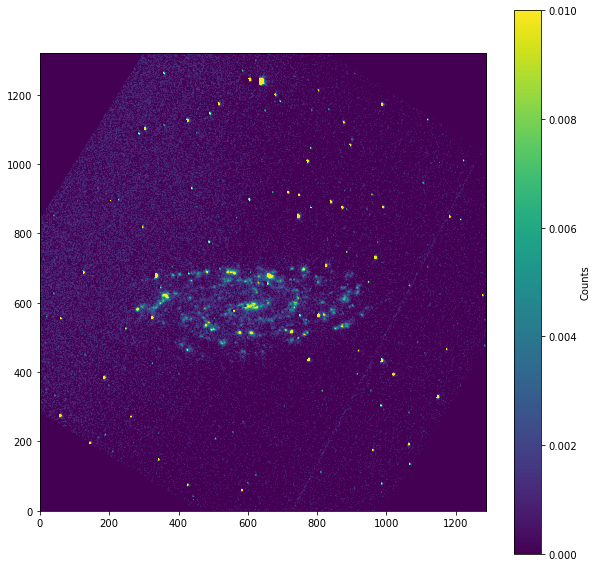

In [21]:
plt.figure("master_Ha-R scale", figsize=[10, 10])
plt.imshow(Ha_R_rotate, vmin=0, vmax=0.01, origin='lower')
plt.colorbar(label='Counts')
plt.show() 

### Transformando la galaxia eliptica en galaxia circular

In [22]:
transform = ndimage.zoom(Ha_R_rotate, [3, 1])

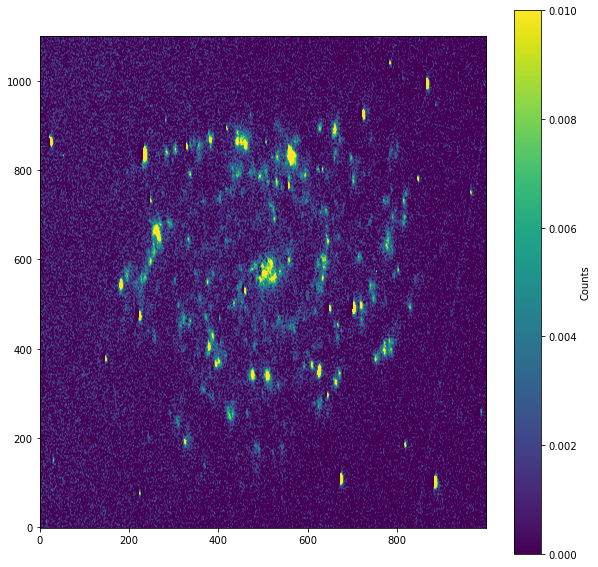

In [23]:
plt.figure("master_Ha-R scale", figsize=[10, 10])
plt.imshow(transform[1200:2300,100:1100], vmin=0, vmax=0.01, origin='lower')
plt.colorbar(label='Counts')
plt.show() 

## Buscando las regiones de Ha

Ahora vamos a buscar las regiones HII de nuestra galaxia.

Para ello usaremos la herramienta que habíamos utilizado anteriormente para la detección de estrellas `DAOStarFinder`.

Encontramos 113 fuentes de HII aunque tenemos que tener cuidado con los parámetros que elegimos ya que se nos puede colar estructura que no queremos o estrellas. Para evitar esto, es bueno utilizar máscaras para evitar regiones fuera de la galaxia.

In [24]:
mean_H, median_H, std_H = sigma_clipped_stats(transform[1200:2300,100:1100], sigma=0.8)  
daofind_H = DAOStarFinder(fwhm=10, threshold=150*std_H, sharplo = 0., sharphi=200, roundlo=0.01, roundhi=500)

star_mask = np.zeros(transform[1200:2300,100:1100].shape, dtype=bool)

star_mask[:200,0:250] = True

star_mask[:,0:125] = True
star_mask[879:,:] = True
star_mask[:,835:] = True
star_mask[0:226,674:] = True
star_mask[820:,0:247] = True

sources_H = daofind_H(transform[1200:2300,100:1100] - median_H, mask=star_mask)  
for col in sources_H.colnames:  
    sources_H[col].info.format = '%.8g'  # for consistent table output
print(sources_H)  

 id xcentroid ycentroid  sharpness   ... sky     peak        flux       mag     
--- --------- --------- ------------ ... --- ------------ --------- ------------
  1 673.34791 108.28638   0.58854268 ...   0   0.28304639 89.848598   -4.8837783
  2 462.70304 258.05397   0.54279086 ...   0 0.0046983214 1.2345386  -0.22876165
  3 624.21743 274.30205   0.60176744 ...   0 0.0064568319 1.0659275 -0.069319183
  4 613.55167  278.6011   0.43907255 ...   0  0.003923736 1.0261012 -0.027975484
  5 643.86824 296.38696   0.63987169 ...   0  0.014474816 3.5996975    -1.390665
  6 632.08163 300.79437   0.31789377 ...   0 0.0013197177 1.1323417  -0.13494377
  7 532.54896  318.6302   0.81185107 ...   0 0.0067532225 1.1485891  -0.15041173
  8 508.69781 339.63691   0.57408677 ...   0   0.02770378 4.9978188   -1.7469513
  9 669.65575 345.57069   0.58891515 ...   0  0.011462141 2.5940775   -1.0349574
 10  624.1418 349.24394   0.64078115 ...   0  0.050128334 10.201395   -2.5216489
...       ...       ...     

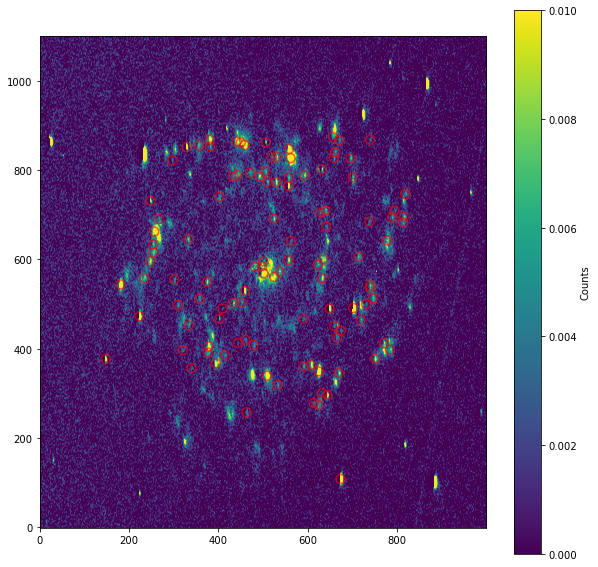

In [25]:
plt.figure("HII regions", figsize=[10, 10])
positions_H = np.transpose((sources_H['xcentroid'], sources_H['ycentroid']))
apertures_H = CircularAperture(positions_H, r=10.)
plt.imshow(transform[1200:2300,100:1100], vmin=0, vmax=0.01, origin='lower')
plt.colorbar(label='Counts')
apertures_H.plot(color='red', lw=1.5, alpha=0.6)
plt.show()

## Trazando todas las fuentes de HII encontradas en la galaxia

Ahora vamos a representar estas regiones en `2D` y `3D`.

Las posiciones que nos ha ofrecido `daofind` son respecto a la imagen, por lo tanto vamos a recalcular todas las posiciones respecto al centro de la galaxia.

En el gráfico hemos rescalado el flujo que nos da la barra de color para tener un mayor contraste (aplicando el logaritmo a los datos).

También hemos reescalado el tamaño de las regiones HII, hemos tomado el pico de la distribución medido por `daofind` y lo hemos multiplicado por `5000`.

Para hacer la representación en `3D` hemos supuesto que la anchura de la galaxia es muy pequeña comparada con el tamaño de los brazos.

### Centro de la galaxia

In [26]:
H_x_center = 0 #500
H_y_center = 0 #580

### Centrando los valores del eje `x`

In [27]:
H_x = sources_H['xcentroid'] -500

### Centrando los valores del eje `y`

In [28]:
H_y = sources_H['ycentroid'] -580

### Gráfico de dispersión (*Sccater plot*)

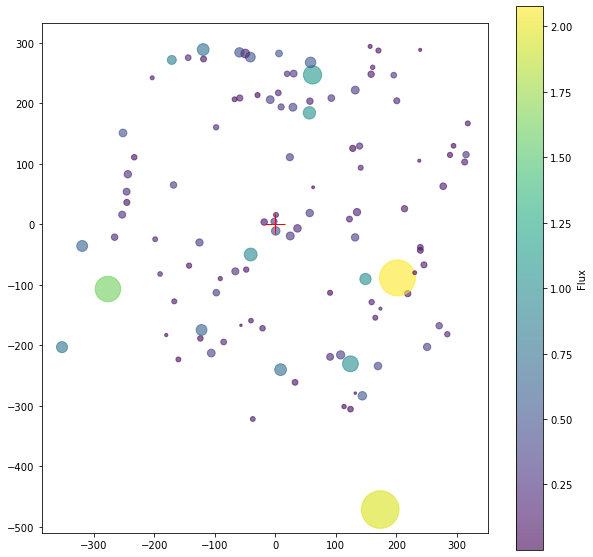

In [29]:
plt.figure('Distribution of HII regions in 2D', figsize=[10, 10])
plt.subplot(111, aspect = 'equal')
plt.scatter(H_x, H_y, vmin=np.log10(np.min(sources_H['flux']))/2, 
            vmax=np.log10(np.max(sources_H['flux'])), c=np.log10(sources_H['flux']), 
            s=5000*sources_H['peak'], alpha=.6)

plt.colorbar(label='Flux')
plt.plot(H_x_center, H_y_center, 'r' ,marker='+', alpha=1, markersize=20)

<ipython-input-30-924f9ad55bb9>:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


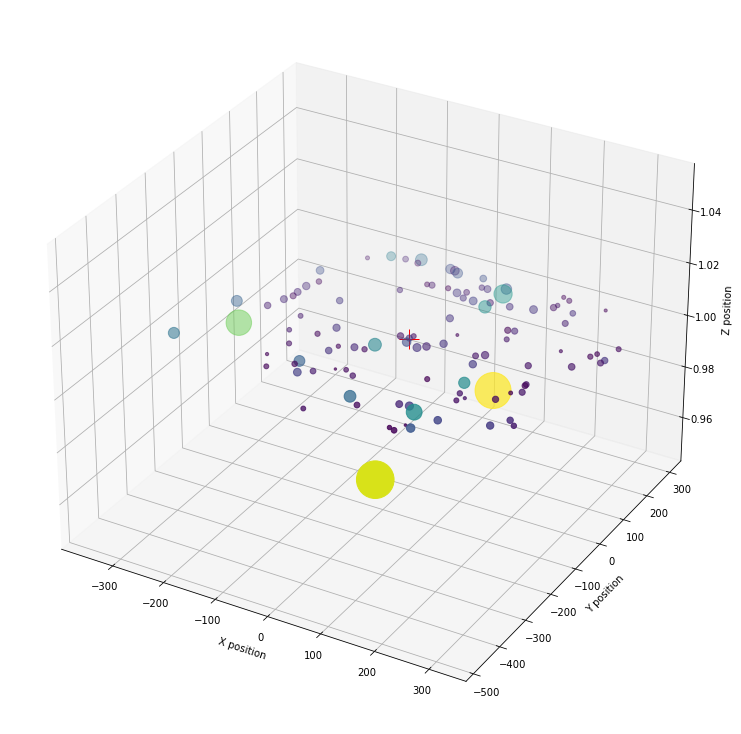

In [30]:
fig = plt.figure('Distribution of HII regions in 3D', figsize=[10, 10])
ax = Axes3D(fig)
ax.scatter(H_x, H_y, 1 , vmin=np.log10(np.min(sources_H['flux'])), 
           vmax=np.log10(np.max(sources_H['flux'])),
           c=np.log10(sources_H['flux']), 
           s=5000*sources_H['peak'])

ax.set_xlabel('X position')
ax.set_ylabel('Y position')
ax.set_zlabel('Z position')
plt.plot(H_x_center, H_y_center,1, 'r' ,marker='+', alpha=1, markersize=20)
    
plt.show()

## Exportación de datos para una simulación de la rotación de la galaxia.

Podemos exportar los datos para poder hacer una simulación muy básica de la rotación de la galaxia.

In [31]:
rotate = ({"x":H_x, "y":H_y, "flux":sources_H['flux'], "peak":sources_H['peak']})

In [32]:
table_df = pd.DataFrame(rotate)
table_df.to_csv('salidas/table_rotation.csv')